In [1]:
# regular imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import math

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# Wrangling
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.cluster import KMeans
from scipy import stats
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr, kruskal

import csv
import acquire
import prepare
import ds_acquire
import ds_prepare


In [2]:
df = acquire.get_bach_df()
df = prepare.clean_college_df(df)

dataframe shape: (71901, 119)


In [3]:
df['major_category'] = df.major_name.apply(prepare.categorize_major)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71901 entries, 0 to 224838
Columns: 120 entries, unit_id_institution to major_category
dtypes: float64(85), int64(2), object(33)
memory usage: 66.4+ MB


In [5]:
df.head()

,unit_id_institution,college_name,institution_control,state_post_code,zip_code,city,region_ipeds,title_IV_eligibility,pred_degree,pred_degree_0and4,...,deg_percent_awarded_construction_trades,deg_percent_awarded_mechanic_repair,deg_percent_awarded_precision_production,deg_percent_awarded_transportation_materials,deg_percent_awarded_visual_and_performing_arts,deg_percent_awarded_health,deg_percent_awarded_business_management,deg_percent_awarded_history,non_deg_seeking,major_category
0,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,3.00,...,0.00,0.00,0.00,0.00,0.02,0.00,0.16,0.00,153.00,Agriculture
1,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,3.00,...,0.00,0.00,0.00,0.00,0.02,0.00,0.16,0.00,153.00,Biology and Life Sciences
2,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,3.00,...,0.00,0.00,0.00,0.00,0.02,0.00,0.16,0.00,153.00,Biology and Life Sciences
5,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,3.00,...,0.00,0.00,0.00,0.00,0.02,0.00,0.16,0.00,153.00,Biology and Life Sciences
6,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,3.00,...,0.00,0.00,0.00,0.00,0.02,0.00,0.16,0.00,153.00,Agriculture


# _______________________________________________________________________________________________ #
### Initial `earnings_df`

In [6]:
earnings_df = pd.read_csv('earnings_df.csv')

In [7]:
earnings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707462 entries, 0 to 707461
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Unnamed: 0                707462 non-null  int64 
 1   earning_year              707462 non-null  int64 
 2   earnings_degree           707462 non-null  int64 
 3   earnings_school_type      707462 non-null  int64 
 4   earnings_major            707462 non-null  int64 
 5   earnings_wage/salary      707462 non-null  int64 
 6   EMPSTAT                   707462 non-null  int64 
 7   METRO                     707462 non-null  int64 
 8   SEX                       707462 non-null  int64 
 9   AGE                       707462 non-null  int64 
 10  earnings_race             707462 non-null  int64 
 11  earnings_speaks_english   707462 non-null  int64 
 12  LANGUAGE                  707462 non-null  int64 
 13  earnings_specific_degree  707462 non-null  int64 
 14  stat

In [8]:
earnings_df.head()

,Unnamed: 0,earning_year,earnings_degree,earnings_school_type,earnings_major,earnings_wage/salary,EMPSTAT,METRO,SEX,AGE,earnings_race,earnings_speaks_english,LANGUAGE,earnings_specific_degree,state_post_code,major_category
0,2762990,2017,101,1,61,38500,1,0,2,31,1,3,1,6100,AL,Medical and Health Sciences and Services
1,2763006,2017,101,1,62,120000,1,4,1,30,2,3,1,6203,AL,Business
2,2763007,2017,101,1,40,50000,1,4,1,26,2,3,1,4002,AL,Interdisciplinary and Multi-Disciplinary Studi...
3,2763029,2017,101,1,61,65000,1,4,2,49,1,3,1,6107,AL,Medical and Health Sciences and Services
4,2763031,2017,101,1,33,42000,1,4,2,34,1,3,1,3301,AL,"English Language, Literature, and Composition"


# _______________________________________________________________________________________________ #
### `earnings_df` pivot table to merge with main df
Newly created pivot table with median earnings by major_category, split by year

In [9]:
earnings_pivot_merge = pd.read_csv('2017_2018_2019_earning_by_major.csv')

In [10]:
earnings_pivot_merge

,major_category,2017,2018,2019,Grand Total
0,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49"
1,Architecture,"68,643.59","71,344.26","75,609.81","215,597.67"
2,"Area, Ethnic, and Civilization Studies","53,999.93","56,155.89","60,997.54","171,153.36"
3,Biology and Life Sciences,"48,851.91","50,004.54","53,463.29","152,319.74"
4,Business,"74,813.94","76,724.07","79,608.39","231,146.40"
5,Communication Technologies,"50,630.58","53,303.00","56,882.68","160,816.25"
6,Communications,"61,311.56","63,458.16","66,997.75","191,767.47"
7,Computer and Information Sciences,"83,482.41","87,552.61","91,321.98","262,357.00"
8,Construction Services,"85,101.29","85,776.30","91,583.25","262,460.84"
9,Cosmetology Services and Culinary Arts,"42,217.78","45,696.22","48,408.92","136,322.92"


In [11]:
new_df = df.merge(earnings_pivot_merge, how='inner', on='major_category')

In [59]:
new_df.shape

(71422, 125)

In [12]:
new_df.head()

,unit_id_institution,college_name,institution_control,state_post_code,zip_code,city,region_ipeds,title_IV_eligibility,pred_degree,pred_degree_0and4,...,deg_percent_awarded_visual_and_performing_arts,deg_percent_awarded_health,deg_percent_awarded_business_management,deg_percent_awarded_history,non_deg_seeking,major_category,2017,2018,2019,Grand Total
0,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,3.00,...,0.02,0.00,0.16,0.00,153.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49"
1,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,3.00,...,0.02,0.00,0.16,0.00,153.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49"
2,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,3.00,...,0.03,0.06,0.23,0.01,481.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49"
3,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,3.00,...,0.03,0.06,0.23,0.01,481.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49"
4,"101,541.00",Judson College,"Private, nonprofit",AL,36756,Marion,5.00,1.00,3.00,3.00,...,0.07,0.24,0.10,0.04,9.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49"


In [13]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71422 entries, 0 to 71421
Columns: 124 entries, unit_id_institution to Grand Total
dtypes: float64(89), int64(2), object(33)
memory usage: 68.1+ MB


In [14]:
# new_df.to_csv('merged_df.csv')

In [15]:
new_df.avg_net_price_public.isnull().sum()

42789

In [16]:
71422 - 42789

28633

In [17]:
new_df.avg_net_price_private.isnull().sum()

33337

In [18]:
new_df.avg_net_price_public.value_counts()

15,020.00    153
15,970.00    140
30,996.00    138
12,566.00    136
17,704.00    125
            ... 
 6,526.00      1
 4,646.00      1
 8,324.00      1
 3,411.00      1
 4,433.00      1
Name: avg_net_price_public, Length: 759, dtype: int64

In [19]:
price_investigation = new_df.groupby(new_df['institution_control'])['avg_net_price_public'].value_counts()

In [20]:
priv_price_investigation = new_df.groupby(new_df['institution_control'])['avg_net_price_private'].value_counts()

In [21]:
price_investigation.info()

<class 'pandas.core.series.Series'>
MultiIndex: 759 entries, ('Public', 15020.0) to ('Public', 44661.0)
Series name: avg_net_price_public
Non-Null Count  Dtype
--------------  -----
759 non-null    int64
dtypes: int64(1)
memory usage: 14.2+ KB


In [22]:
priv_price_investigation.info()

<class 'pandas.core.series.Series'>
MultiIndex: 1547 entries, ('Private, for-profit', 21197.0) to ('Public', 27000.0)
Series name: avg_net_price_private
Non-Null Count  Dtype
--------------  -----
1547 non-null   int64
dtypes: int64(1)
memory usage: 28.8+ KB


In [23]:
price_investigation.to_csv('price_investigation.csv')

In [24]:
priv_price_investigation.to_csv('priv_price_investigation.csv')

In [25]:
# new_df.groupby(new_df['institution_control']=='Public')['avg_net_price_private'].value_counts()

In [26]:
new_df.avg_net_price_private

0                        NaN
1                        NaN
2                        NaN
3                        NaN
4                  16,619.00
                ...         
71417                    NaN
71418                    NaN
71419              29,386.00
71420              18,182.00
71421                    NaN
Name: avg_net_price_private, Length: 71422, dtype: float64

In [27]:
new_df.avg_net_price_program.isnull().sum()

71422

In [28]:
new_df.avg_net_price_other.isnull().sum()

71422

In [29]:
new_df.avg_net_price_public

0                  14,444.00
1                  14,444.00
2                  23,696.00
3                  23,696.00
4                        NaN
                ...         
71417              19,836.00
71418              22,282.00
71419                    NaN
71420                    NaN
71421              12,566.00
Name: avg_net_price_public, Length: 71422, dtype: float64

In [30]:
# new_df.replace(to_replace=new_df['avg_net_price_public'] == 'NaN', value=None)

In [31]:
new_df.avg_net_price_public

0                  14,444.00
1                  14,444.00
2                  23,696.00
3                  23,696.00
4                        NaN
                ...         
71417              19,836.00
71418              22,282.00
71419                    NaN
71420                    NaN
71421              12,566.00
Name: avg_net_price_public, Length: 71422, dtype: float64

For sake of expedition, we are not completing individual application of joining avg_net_price columns.
Instead, Chenchen is uploading her new csv file with appropriate changes to the Google Drive so we can press forward with exploration.

In [2]:
explore_df = pd.read_csv('merged_df_with_avg_price.csv')

In [40]:
explore_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71422 entries, 0 to 71421
Columns: 126 entries, Unnamed: 0 to avg_net_price
dtypes: float64(115), int64(3), object(8)
memory usage: 68.7+ MB


In [41]:
explore_df.head()

,Unnamed: 0,unit_id_institution,college_name,institution_control,state_post_code,zip_code,city,region_ipeds,title_IV_eligibility,pred_degree,...,deg_percent_awarded_health,deg_percent_awarded_business_management,deg_percent_awarded_history.1,non_deg_seeking,major_category,2017,2018,2019,Grand Total,avg_net_price
0,0,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,...,0.00,0.16,0.00,153.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","14,444.00"
1,1,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,...,0.00,0.16,0.00,153.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","14,444.00"
2,2,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,...,0.06,0.23,0.01,481.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","23,696.00"
3,3,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,...,0.06,0.23,0.01,481.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","23,696.00"
4,4,"101,541.00",Judson College,"Private, nonprofit",AL,36756,Marion,5.00,1.00,3.00,...,0.24,0.10,0.04,9.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","16,619.00"


# _______________________________________________________________________________________________ #
## ROI Target Variable Feature Engineering
Creating the ROI formula to create new column with ROI value for each college/major

**Formula:**
ROI =[ 10-yr earnings by degree ] - [College Cost (tuition,fees,books) + Counter Earnings(14-yr earnings of HS diploma ]

# _________________________________ #
##### 5-yr ROI

In [3]:
median_earnings_by_degree_5yr = (explore_df['2017'] + explore_df['2018'] + explore_df['2019'] + explore_df['2019']*1.02 + (explore_df['2019']*1.02)*1.02)

In [4]:
net_college_cost = explore_df['avg_net_price']

In [5]:

counter_earnings_5yr = (39070*9)

In [6]:
explore_df['roi_5yr'] = median_earnings_by_degree_5yr - (net_college_cost+counter_earnings_5yr)

In [7]:
explore_df['roi_5yr']

0                 -65,075.75
1                 -65,075.75
2                 -74,327.75
3                 -74,327.75
4                 -67,250.75
                ...         
71417            -197,026.85
71418            -199,472.85
71419            -206,576.85
71420            -195,372.85
71421            -189,756.85
Name: roi_5yr, Length: 71422, dtype: float64

# _________________________________ #
##### 10-yr ROI

In [8]:
median_earnings_by_degree_10yr = (explore_df['2017'] + explore_df['2018'] + explore_df['2019'] + explore_df['2019']*1.02 + (explore_df['2019']*1.02)*1.02) + ((explore_df['2019']*1.02)*1.02)*1.02 + (((explore_df['2019']*1.02)*1.02)*1.02)*1.02 + ((((explore_df['2019']*1.02)*1.02)*1.02)*1.02)*1.02 + (((((explore_df['2019']*1.02)*1.02)*1.02)*1.02)*1.02)*1.02 + ((((((explore_df['2019']*1.02)*1.02)*1.02)*1.02)*1.02)*1.02)*1.02

In [9]:
# net_college_cost = explore_df['avg_net_price']

In [10]:

counter_earnings_10yr = (39070*14)

In [11]:
explore_df['roi_10yr'] = median_earnings_by_degree_10yr - (net_college_cost+counter_earnings_10yr)

In [12]:
explore_df['roi_10yr']

0                  78,598.88
1                  78,598.88
2                  69,346.88
3                  69,346.88
4                  76,423.88
                ...         
71417            -217,577.31
71418            -220,023.31
71419            -227,127.31
71420            -215,923.31
71421            -210,307.31
Name: roi_10yr, Length: 71422, dtype: float64

In [13]:
explore_df['roi_10yr'].value_counts()

 287,834.37    828
  67,253.91    469
 407,868.78    426
   8,110.75    385
 232,829.01    260
              ... 
 -38,878.57      1
 -30,333.57      1
 -48,016.57      1
 -50,257.57      1
-210,307.31      1
Name: roi_10yr, Length: 30287, dtype: int64

In [14]:
explore_df.shape

(71422, 128)

In [15]:
explore_df.head()

,Unnamed: 0,unit_id_institution,college_name,institution_control,state_post_code,zip_code,city,region_ipeds,title_IV_eligibility,pred_degree,...,deg_percent_awarded_history.1,non_deg_seeking,major_category,2017,2018,2019,Grand Total,avg_net_price,roi_5yr,roi_10yr
0,0,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,...,0.00,153.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","14,444.00","-65,075.75","78,598.88"
1,1,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,...,0.00,153.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","14,444.00","-65,075.75","78,598.88"
2,2,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,...,0.01,481.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","23,696.00","-74,327.75","69,346.88"
3,3,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,...,0.01,481.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","23,696.00","-74,327.75","69,346.88"
4,4,"101,541.00",Judson College,"Private, nonprofit",AL,36756,Marion,5.00,1.00,3.00,...,0.04,9.00,Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","16,619.00","-67,250.75","76,423.88"


In [16]:
explore_df['deg_percent_awarded_history.1'].sum()

866.0209999999998

In [17]:
explore_df.groupby(explore_df['unit_id_institution'])['deg_percent_awarded_history.1'].sum()

unit_id_institution
100,654.00                   0.00
100,663.00                   0.46
100,690.00                   0.00
100,706.00                   0.41
100,724.00                   0.14
                     ...         
494,287.00                   0.00
494,630.00                   0.00
494,685.00                   0.00
494,737.00                   0.00
494,807.00                   0.00
Name: deg_percent_awarded_history.1, Length: 2706, dtype: float64

In [18]:
explore_df.deg_percent_awarded_engineering

0                       0.12
1                       0.12
2                       0.19
3                       0.19
4                       0.00
                ...         
71417                   0.00
71418                   0.00
71419                   0.00
71420                   0.00
71421                   0.10
Name: deg_percent_awarded_engineering, Length: 71422, dtype: float64

In [19]:
explore_df.groupby(explore_df['college_name'])['deg_percent_awarded_engineering'].agg([sum, 'mean', 'median'], axis=1)

,sum,mean,median
college_name,,,
AI Miami International University of Art and Design,0.00,0.00,0.00
ASA College,0.00,0.00,0.00
ATA College,0.00,0.00,0.00
ATI College-Norwalk,0.00,0.00,0.00
Aarhus University,0.00,NaN,NaN
...,...,...,...
York College of Pennsylvania,3.02,0.06,0.06
York St John University,0.00,NaN,NaN
York University,0.00,NaN,NaN


In [20]:
explore_df.college_name.nunique()

3002

In [21]:
# explore_df.to_csv('df_exploration_ready_with_ROI.csv')

# __________________________________________________________________________________ #
# Exploration

### Variables to explore:

- `avg_net_price`
- `full_time_net_tuition_revenue`
- `avg_faculty_salary`

- `admission_rate`
- `ACT_score_mid`
- `avg_sat_admitted`
- `required_score`
- `share_of_part_time`


In [2]:
# regular imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import math

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# Wrangling
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.cluster import KMeans
from scipy import stats
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr, kruskal

import csv
import acquire
import prepare
import ds_acquire
import ds_prepare


In [3]:
explore_df = pd.read_csv('df_exploration_ready_with_ROI.csv')

In [4]:
explore_df.head()

,Unnamed: 0,unit_id_institution,college_name,institution_control,state_post_code,zip_code,city,region_ipeds,title_IV_eligibility,pred_degree,...,deg_percent_awarded_history.1,non_deg_seeking,avg_net_price,major_category,2017,2018,2019,Grand Total,roi_5yr,roi_10yr
0,0,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,...,0.00,153.00,"14,444.00",Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","-65,075.75","78,598.88"
1,1,"100,654.00",Alabama A & M University,Public,AL,35762,Normal,5.00,1.00,3.00,...,0.00,153.00,"14,444.00",Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","-65,075.75","78,598.88"
2,2,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,...,0.01,481.00,"23,696.00",Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","-74,327.75","69,346.88"
3,3,"100,858.00",Auburn University,Public,AL,36849,Auburn,5.00,1.00,3.00,...,0.01,481.00,"23,696.00",Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","-74,327.75","69,346.88"
4,4,"101,541.00",Judson College,"Private, nonprofit",AL,36756,Marion,5.00,1.00,3.00,...,0.04,9.00,"16,619.00",Agriculture,"57,605.69","55,517.87","61,388.93","174,512.49","-67,250.75","76,423.88"


In [5]:
explore_df.describe()

,Unnamed: 0,unit_id_institution,region_ipeds,title_IV_eligibility,pred_degree,pred_degree_0and4,degree_code,major_code,branch_number,avg_net_price_public,...,deg_percent_awarded_business_management,deg_percent_awarded_history.1,non_deg_seeking,avg_net_price,2017,2018,2019,Grand Total,roi_5yr,roi_10yr
count,"68,546.00","68,546.00","68,546.00","68,546.00","68,546.00","68,224.00","68,546.00","68,546.00","68,546.00","68,546.00",...,"68,537.00","68,537.00","63,395.00","68,546.00","68,546.00","68,546.00","68,546.00","68,546.00","68,546.00","68,546.00"
mean,"34,272.50","196,690.49",4.19,1.01,2.95,2.96,3.00,"3,329.54",1.99,"6,088.92",...,0.19,0.01,400.64,"19,177.97","58,907.64","60,222.86","63,109.75","182,240.24","-58,536.40","94,641.54"
std,"19,787.67","73,389.01",2.11,0.18,0.25,0.23,0.00,"1,645.53",4.55,"7,771.83",...,0.12,0.01,881.83,"8,017.83","13,578.66","13,983.84","14,610.67","41,894.70","72,568.04","152,988.73"
min,0.00,"100,654.00",0.00,1.00,0.00,1.00,3.00,100.00,1.00,"-1,133.00",...,0.00,0.00,1.00,"-1,133.00","37,639.57","35,450.00","31,651.85","109,223.68","-206,576.85","-227,127.31"
25%,"17,136.25","153,603.00",2.00,1.00,3.00,3.00,3.00,"1,604.00",1.00,0.00,...,0.13,0.00,29.00,"14,166.00","48,851.91","50,004.54","53,039.55","152,319.74","-111,077.49","-12,142.25"
50%,"34,272.50","190,415.00",4.00,1.00,3.00,3.00,3.00,"3,902.00",1.00,0.00,...,0.18,0.01,111.00,"18,860.00","54,382.32","56,419.95","58,422.98","169,831.29","-81,931.92","45,495.91"
75%,"51,408.75","217,864.00",5.00,1.00,3.00,3.00,3.00,"5,007.00",1.00,"13,789.00",...,0.24,0.02,383.00,"23,863.00","72,585.53","72,475.08","79,448.61","224,509.21","8,691.00","250,435.37"
max,"68,545.00","492,962.00",9.00,5.00,4.00,3.00,3.00,"5,401.00",74.00,"44,661.00",...,1.00,0.11,"13,137.00","52,062.00","97,692.31","91,686.88","100,554.88","277,838.89","133,392.15","493,363.40"


# _______________________________________________________ #
### Financial Specific Questions
- `avg_net_price`
- `full_time_net_tuition_revenue`
- `avg_faculty_salary`

In [6]:
explore_df.avg_net_price.value_counts()

     0.00    1828
15,020.00     153
21,588.00     142
15,970.00     140
30,996.00     138
             ... 
 4,212.00       1
 4,745.00       1
 4,702.00       1
 9,100.00       1
 4,433.00       1
Name: avg_net_price, Length: 2270, dtype: int64

In [9]:
explore_df.avg_net_price.isnull().sum()

0

In [7]:
explore_df.avg_net_price.describe()

count              68,546.00
mean               19,177.97
std                 8,017.83
min                -1,133.00
25%                14,166.00
50%                18,860.00
75%                23,863.00
max                52,062.00
Name: avg_net_price, dtype: float64

In [40]:
explore_df.groupby('college_name').avg_net_price.value_counts().sort_values()

college_name                                               avg_net_price
Middlebury Institute of International Studies at Monterey       0.00          1
Intellitec College-Colorado Springs                        17,845.00          1
Research College of Nursing                                     0.00          1
Bryant & Stratton College-Syracuse North                   10,593.00          1
Renton Technical College                                    6,123.00          1
                                                                           ... 
University of Minnesota-Twin Cities                        17,479.00        114
Arizona State University Campus Immersion                  11,644.00        114
Ohio State University-Main Campus                          17,704.00        125
University of Washington-Seattle Campus                    12,566.00        136
Pennsylvania State University-Main Campus                  30,996.00        138
Name: avg_net_price, Length: 2593, dtype: int64

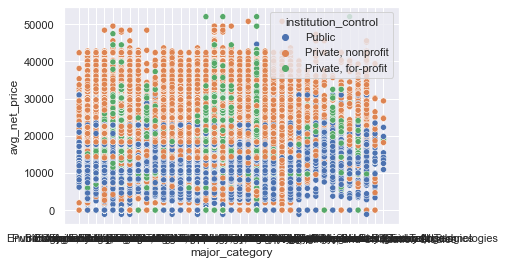

In [41]:
sns.scatterplot(explore_df["major_category"], explore_df["avg_net_price"], hue=explore_df["institution_control"])
plt.show()

In [38]:
explore_df.groupby('major_category').avg_net_price.value_counts().sort_values()

major_category                                              avg_net_price
Fine Arts                                                   17,188.00          1
Interdisciplinary and Multi-Disciplinary Studies (General)  19,177.00          1
                                                            19,142.00          1
                                                            19,078.00          1
                                                            19,068.00          1
                                                                            ... 
Criminal Justice and Fire Protection                             0.00         92
Public Affairs, Policy, and Social Work                          0.00        109
Computer and Information Sciences                                0.00        213
Medical and Health Sciences and Services                         0.00        299
Business                                                         0.00        362
Name: avg_net_price, Length: 30287,

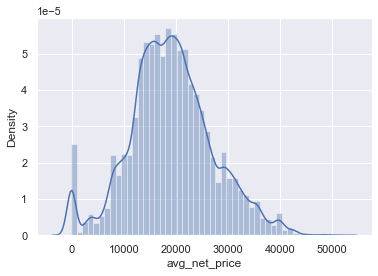

In [8]:
sns.distplot(explore_df['avg_net_price']) 
plt.show()

In [10]:
explore_df.full_time_net_tuition_revenue.value_counts()

10,873.00    158
18,384.00    142
29,309.00    138
17,912.00    136
 5,991.00    130
            ... 
 5,203.00      1
   908.00      1
 1,313.00      1
   846.00      1
   684.00      1
Name: full_time_net_tuition_revenue, Length: 2458, dtype: int64

In [11]:
explore_df.full_time_net_tuition_revenue.isnull().sum()

30

In [13]:
(explore_df['full_time_net_tuition_revenue']==0).sum()

115

In [12]:
explore_df.full_time_net_tuition_revenue.describe()

count              68,516.00
mean               13,882.58
std                11,850.51
min                     0.00
25%                 7,624.00
50%                12,245.00
75%                17,418.00
max               455,440.00
Name: full_time_net_tuition_revenue, dtype: float64

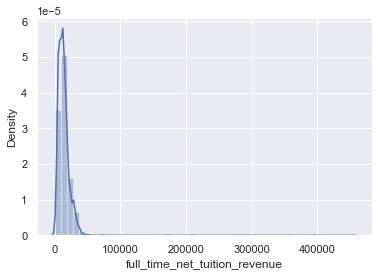

In [14]:
sns.distplot(explore_df['full_time_net_tuition_revenue']) 
plt.show()

In [16]:
explore_df.avg_faculty_salary.value_counts()

14,291.00    240
10,192.00    172
 8,377.00    170
 7,426.00    162
10,744.00    156
            ... 
 6,428.00      1
 9,500.00      1
10,599.00      1
 7,951.00      1
 9,751.00      1
Name: avg_faculty_salary, Length: 2153, dtype: int64

In [17]:
explore_df.avg_faculty_salary.isnull().sum()

808

In [18]:
(explore_df['avg_faculty_salary']==0).sum()

0

In [19]:
explore_df.avg_faculty_salary.describe()

count              67,738.00
mean                8,443.29
std                 2,585.69
min                   453.00
25%                 6,693.00
50%                 8,055.00
75%                 9,806.00
max                20,483.00
Name: avg_faculty_salary, dtype: float64

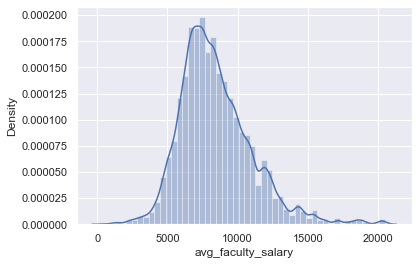

In [20]:
sns.distplot(explore_df['avg_faculty_salary']) 
plt.show()

In [80]:
100*1.02

102.0

In [81]:
(100*1.02)*1.02

104.04

In [87]:
100*(1.02**2)

104.03999999999999

In [85]:
((100*1.02)*1.02)*1.02

106.1208

In [86]:
100*1.02**3

106.12080000000002

# _______________________________________________________ #
### Debt Specific Questions
- `med_debt_pell_students`
- `median_debt_non_pell`
- `median_debt_completed`

In [21]:
explore_df.med_debt_pell_students.value_counts()

19,500.00    2614
15,000.00    2192
19,000.00    1837
21,500.00    1591
20,500.00    1295
             ... 
 3,909.00       1
 7,300.00       1
10,264.00       1
 3,750.00       1
 8,655.00       1
Name: med_debt_pell_students, Length: 970, dtype: int64

In [22]:
explore_df.med_debt_pell_students.isnull().sum()

1350

In [23]:
(explore_df['med_debt_pell_students']==0).sum()

0

In [24]:
explore_df.med_debt_pell_students.describe()

count              67,196.00
mean               17,340.06
std                 4,450.16
min                 3,500.00
25%                14,375.00
50%                17,500.00
75%                20,500.00
max                35,629.00
Name: med_debt_pell_students, dtype: float64

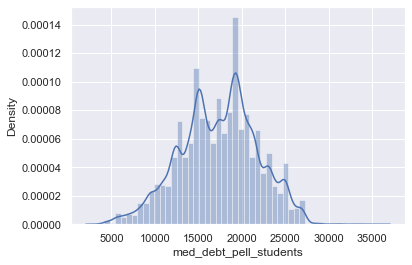

In [25]:
sns.distplot(explore_df['med_debt_pell_students']) 
plt.show()

In [26]:
explore_df.median_debt_non_pell.value_counts()

15,000.00    4898
19,500.00    3744
12,000.00    3595
12,500.00    3205
13,000.00    2564
             ... 
11,168.00       1
 8,083.00       1
26,850.00       1
 5,454.00       1
 3,750.00       1
Name: median_debt_non_pell, Length: 796, dtype: int64

In [27]:
explore_df.median_debt_non_pell.isnull().sum()

1350

In [28]:
(explore_df['median_debt_non_pell']==0).sum()

0

In [29]:
explore_df.median_debt_non_pell.describe()

count              67,196.00
mean               15,029.45
std                 4,093.07
min                 2,996.00
25%                12,256.00
50%                14,768.00
75%                18,209.00
max                40,000.00
Name: median_debt_non_pell, dtype: float64

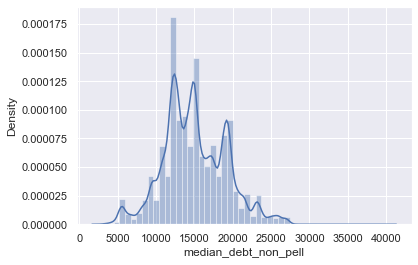

In [30]:
sns.distplot(explore_df['median_debt_non_pell']) 
plt.show()

In [ ]:
explore_df.median_debt_completed.value_counts()

27,000.00    7460
25,000.00    4927
26,000.00    2948
21,500.00    1942
20,500.00    1743
             ... 
30,735.00       1
 7,877.00       1
26,366.00       1
25,750.00       1
11,250.00       1
Name: median_debt_completed, Length: 955, dtype: int64

In [ ]:
explore_df.median_debt_completed.isnull().sum()

1005

In [ ]:
(explore_df['median_debt_completed']==0).sum()

0

In [ ]:
explore_df.median_debt_completed.describe()

count              67,541.00
mean               22,679.90
std                 4,649.78
min                 3,500.00
25%                20,490.00
50%                23,250.00
75%                26,000.00
max                45,881.00
Name: median_debt_completed, dtype: float64

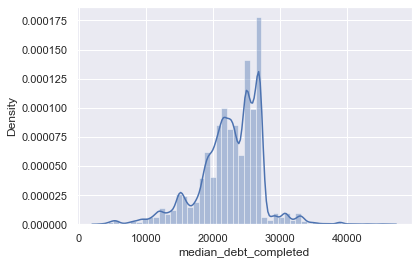

In [ ]:
sns.distplot(explore_df['median_debt_completed']) 
plt.show()

# _______________________________________________________ #
### Admission Specific Questions
- `admission_rate`
- `ACT_score_mid`
- `avg_sat_admitted`
- `required_score`
- `share_of_part_time`

In [42]:
explore_df.admission_rate.value_counts()

1.00    287
0.78    203
0.69    191
0.49    189
0.84    168
       ... 
0.39      1
0.44      1
0.64      1
0.98      1
0.59      1
Name: admission_rate, Length: 1496, dtype: int64

In [43]:
explore_df.admission_rate.isnull().sum()

7173

In [44]:
(explore_df['admission_rate']==0).sum()

2

In [45]:
explore_df.admission_rate.describe()

count              61,373.00
mean                    0.66
std                     0.20
min                     0.00
25%                     0.56
50%                     0.69
75%                     0.81
max                     1.00
Name: admission_rate, dtype: float64

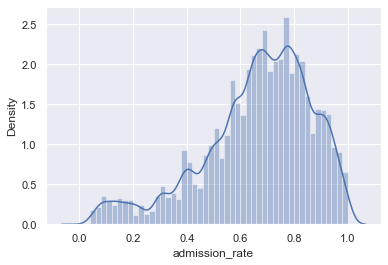

In [46]:
sns.distplot(explore_df['admission_rate']) 
plt.show()

In [47]:
explore_df.ACT_score_mid.value_counts()

23.00    7461
24.00    6422
22.00    6001
25.00    4837
21.00    4690
20.00    4035
26.00    3533
28.00    2323
27.00    1880
19.00    1843
29.00    1712
30.00    1591
32.00    1096
18.00    1014
34.00     997
31.00     938
33.00     933
17.00     381
16.00     149
15.00      73
35.00      61
36.00      26
Name: ACT_score_mid, dtype: int64

In [48]:
explore_df.ACT_score_mid.isnull().sum()

16550

In [49]:
(explore_df['ACT_score_mid']==0).sum()

0

In [50]:
explore_df.ACT_score_mid.describe()

count              51,996.00
mean                   24.19
std                     3.74
min                    15.00
25%                    22.00
50%                    24.00
75%                    26.00
max                    36.00
Name: ACT_score_mid, dtype: float64

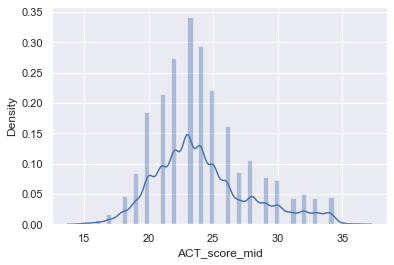

In [51]:
sns.distplot(explore_df['ACT_score_mid']) 
plt.show()

In [52]:
explore_df.avg_sat_admitted.value_counts()

1,120.00    888
1,105.00    561
1,133.00    554
1,135.00    463
1,050.00    414
           ... 
1,522.00      3
1,296.00      3
1,343.00      1
  908.00      1
1,476.00      1
Name: avg_sat_admitted, Length: 444, dtype: int64

In [53]:
explore_df.avg_sat_admitted.isnull().sum()

15796

In [54]:
(explore_df['avg_sat_admitted']==0).sum()

0

In [55]:
explore_df.avg_sat_admitted.describe()

count              52,750.00
mean                1,163.76
std                   124.43
min                   785.00
25%                 1,082.00
50%                 1,140.00
75%                 1,229.00
max                 1,566.00
Name: avg_sat_admitted, dtype: float64

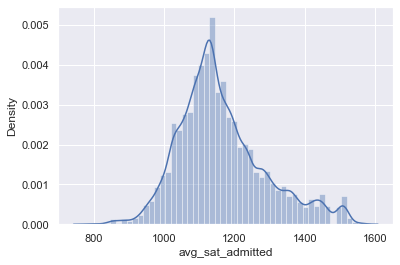

In [56]:
sns.distplot(explore_df['avg_sat_admitted']) 
plt.show()

In [57]:
explore_df.required_score.value_counts()

1.00    47941
5.00     5447
2.00     4609
3.00     3419
Name: required_score, dtype: int64

In [58]:
explore_df.required_score.isnull().sum()

7130

In [59]:
(explore_df['required_score']==0).sum()

0

In [60]:
explore_df.required_score.describe()

count              61,416.00
mean                    1.54
std                     1.19
min                     1.00
25%                     1.00
50%                     1.00
75%                     1.00
max                     5.00
Name: required_score, dtype: float64

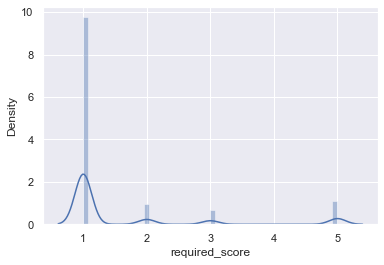

In [61]:
sns.distplot(explore_df['required_score']) 
plt.show()

In [62]:
explore_df.share_of_part_time.value_counts()

0.00    2040
0.07     235
0.04     233
0.08     222
0.06     210
        ... 
0.43       1
0.67       1
0.61       1
0.76       1
0.75       1
Name: share_of_part_time, Length: 1758, dtype: int64

In [63]:
explore_df.share_of_part_time.isnull().sum()

70

In [64]:
(explore_df['share_of_part_time']==0).sum()

2040

In [65]:
explore_df.share_of_part_time.describe()

count              68,476.00
mean                    0.14
std                     0.16
min                     0.00
25%                     0.03
50%                     0.09
75%                     0.18
max                     1.00
Name: share_of_part_time, dtype: float64

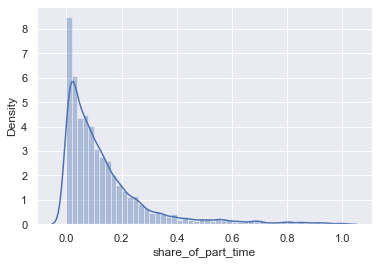

In [66]:
sns.distplot(explore_df['share_of_part_time']) 
plt.show()

<AxesSubplot:xlabel='roi_10yr', ylabel='full_time_net_tuition_revenue'>

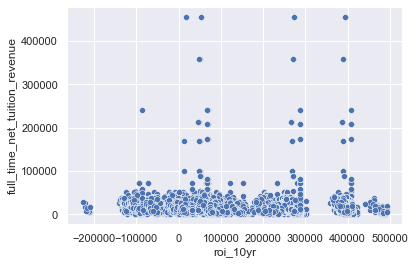

In [68]:
sns.scatterplot(explore_df["roi_10yr"], explore_df["full_time_net_tuition_revenue"])

<AxesSubplot:xlabel='roi_10yr', ylabel='med_debt_pell_students'>

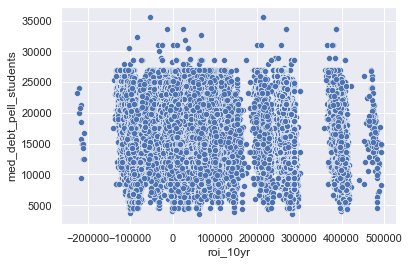

In [70]:
sns.scatterplot(explore_df["roi_10yr"], explore_df["med_debt_pell_students"])

<AxesSubplot:xlabel='roi_10yr', ylabel='median_debt_non_pell'>

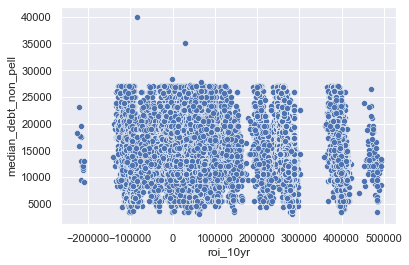

In [71]:
sns.scatterplot(explore_df["roi_10yr"], explore_df["median_debt_non_pell"])

<AxesSubplot:xlabel='roi_10yr', ylabel='median_debt_completed'>

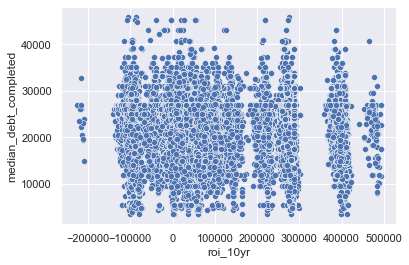

In [72]:
sns.scatterplot(explore_df["roi_10yr"], explore_df["median_debt_completed"])

<AxesSubplot:xlabel='roi_10yr', ylabel='avg_faculty_salary'>

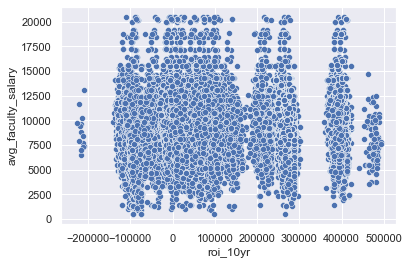

In [69]:
sns.scatterplot(explore_df["roi_10yr"], explore_df["avg_faculty_salary"])

Is there a relationship between avg_net_price and ROI_10yr?


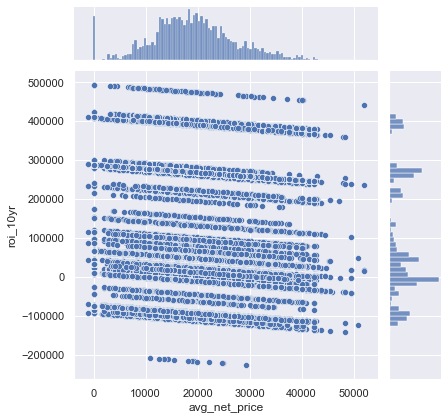

In [15]:
print("Is there a relationship between avg_net_price and ROI_10yr?")
sns.jointplot(x="avg_net_price", y="roi_10yr", data=explore_df)
plt.xlabel("Avg_net_price_per_institution")
plt.ylabel("ROI 10yr")
plt.show()

Is there a relationship between full_time_net_tuition_revenue and ROI_10yr?


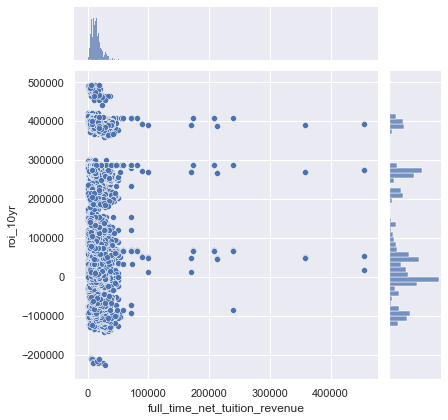

In [73]:
print("Is there a relationship between full_time_net_tuition_revenue and ROI_10yr?")
sns.jointplot(x="full_time_net_tuition_revenue", y="roi_10yr", data=explore_df)
plt.xlabel("Fill Time Net Tuition Revenue")
plt.ylabel("ROI 10yr")
plt.show()

Is there a relationship between avg_faculty_salary and ROI_10yr?


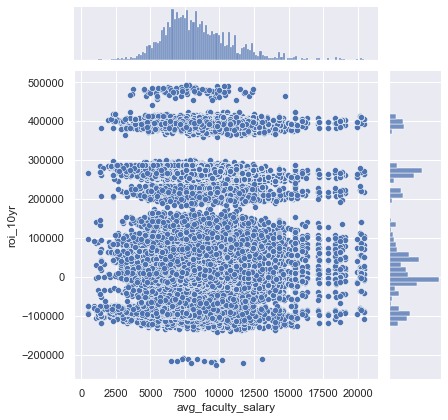

In [74]:
print("Is there a relationship between avg_faculty_salary and ROI_10yr?")
sns.jointplot(x="avg_faculty_salary", y="roi_10yr", data=explore_df)
plt.xlabel("Avg Faculty Salary")
plt.ylabel("ROI 10yr")
plt.show()

Is there a relationship between admission_rate and ROI_10yr?


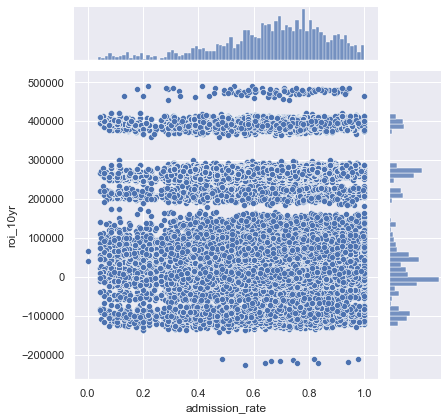

In [75]:
print("Is there a relationship between admission_rate and ROI_10yr?")
sns.jointplot(x="admission_rate", y="roi_10yr", data=explore_df)
plt.xlabel("Admission Rate")
plt.ylabel("ROI 10yr")
plt.show()

Is there a relationship between ACT_score_mid and ROI_10yr?


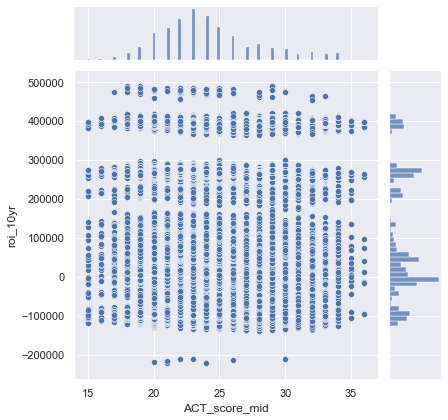

In [76]:
print("Is there a relationship between ACT_score_mid and ROI_10yr?")
sns.jointplot(x="ACT_score_mid", y="roi_10yr", data=explore_df)
plt.xlabel("Mid ACT score admitted")
plt.ylabel("ROI 10yr")
plt.show()

Is there a relationship between avg_sat_admitted and ROI_10yr?


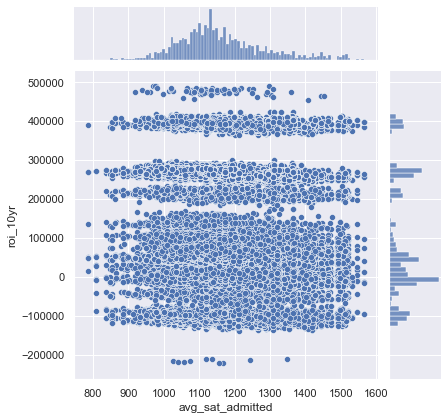

In [77]:
print("Is there a relationship between avg_sat_admitted and ROI_10yr?")
sns.jointplot(x="avg_sat_admitted", y="roi_10yr", data=explore_df)
plt.xlabel("Avg SAT score admitted")
plt.ylabel("ROI 10yr")
plt.show()

Is there a relationship between required_score and ROI_10yr?


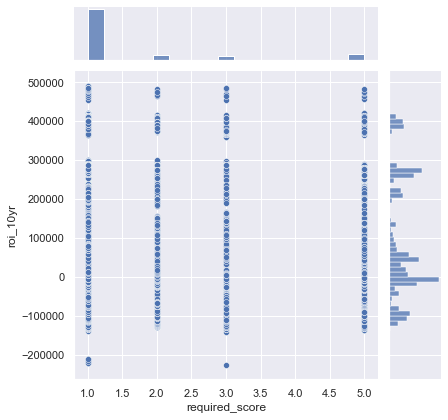

In [78]:
print("Is there a relationship between required_score and ROI_10yr?")
sns.jointplot(x="required_score", y="roi_10yr", data=explore_df)
plt.xlabel("Required Score (unsure which score)")
plt.ylabel("ROI 10yr")
plt.show()

Is there a relationship between share_of_part_time and ROI_10yr?


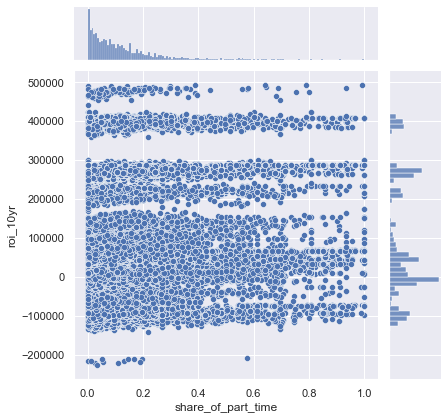

In [79]:
print("Is there a relationship between share_of_part_time and ROI_10yr?")
sns.jointplot(x="share_of_part_time", y="roi_10yr", data=explore_df)
plt.xlabel("Portion of part time students")
plt.ylabel("ROI 10yr")
plt.show()

# ___________________________________________ #
### Train_Test_Split for further exploration

In [ ]:
train, validate, test = prepare.split_data(explore_df)


In [ ]:
# Define function which plots a categorical and continuous var
def plot_categorical_and_continuous_vars(df, categorical, continuous):
    df_sample = df.sample(2000)
    plt.figure()
    sns.countplot(x=categorical, data=df_sample)
    plt.figure()
    sns.swarmplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.boxplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.violinplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.barplot(x=categorical, y=continuous, data=df_sample)